## `All Imports`

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import time
from scipy.stats import chi2_contingency, pointbiserialr, f_oneway
from IPython.display import display
import os
import datetime
import shutil

## `Loading & Pre-processing Dataset`

In [3]:
MAIN_DATA = pd.read_csv("Electric_Vehicle_Data.csv")

# Total Rows & Rows with NaN (even single one of it)
print("Total rows:", len(MAIN_DATA))
print("Rows with NaN:", len(MAIN_DATA[MAIN_DATA.isnull().any(axis=1)]))
print(
    "\nThus, simply dropping all the rows with even a single NaN value as its almost a negligible number compared to total rows!"
)

# Dropping rows with NaN (even single one of it amongst the columns)
MAIN_DATA = MAIN_DATA.dropna()

# Printing all the total rows now
print("\nTotal rows Now:", len(MAIN_DATA))

MAIN_DATA.drop(columns=["DOL Vehicle ID", "2020 Census Tract", "Vehicle Location",
               "Legislative District", "Base MSRP", "City", "State", "Postal Code"], inplace=True)

MAIN_DATA = MAIN_DATA.reindex(columns=MAIN_DATA.nunique().sort_values(ascending=False).index)

Total rows: 181458
Rows with NaN: 403

Thus, simply dropping all the rows with even a single NaN value as its almost a negligible number compared to total rows!

Total rows Now: 181055


In [4]:
MAIN_DATA

,VIN (1-10),Model,Electric Range,Electric Utility,Make,County,Model Year,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Vehicle Type
0,WAUTPBFF4H,A3,16,CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),AUDI,King,2017,Not eligible due to low battery range,Plug-in Hybrid Electric Vehicle (PHEV)
1,WAUUPBFF2J,A3,16,PUGET SOUND ENERGY INC,AUDI,Thurston,2018,Not eligible due to low battery range,Plug-in Hybrid Electric Vehicle (PHEV)
2,5YJSA1E22H,MODEL S,210,PUGET SOUND ENERGY INC,TESLA,Thurston,2017,Clean Alternative Fuel Vehicle Eligible,Battery Electric Vehicle (BEV)
3,1C4JJXP62M,WRANGLER,25,PUGET SOUND ENERGY INC,JEEP,Thurston,2021,Not eligible due to low battery range,Plug-in Hybrid Electric Vehicle (PHEV)
4,5YJ3E1EC9L,MODEL 3,308,PACIFICORP,TESLA,Yakima,2020,Clean Alternative Fuel Vehicle Eligible,Battery Electric Vehicle (BEV)
...,...,...,...,...,...,...,...,...,...
181453,50EA1TEA7P,AIR,0,PUD NO 1 OF DOUGLAS COUNTY,LUCID,Douglas,2023,Eligibility unknown as battery range has not b...,Battery Electric Vehicle (BEV)
181454,1C4JJXP60N,WRANGLER,21,BONNEVILLE POWER ADMINISTRATION||AVISTA CORP||...,JEEP,Spokane,2022,Not eligible due to low battery range,Plug-in Hybrid Electric Vehicle (PHEV)
181455,5YJ3E1EA0M,MODEL 3,0,PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),TESLA,King,2021,Eligibility unknown as battery range has not b...,Battery Electric Vehicle (BEV)
181456,5YJ3E1EC8L,MODEL 3,308,BONNEVILLE POWER ADMINISTRATION||PUD NO 1 OF C...,TESLA,Clark,2020,Clean Alternative Fuel Vehicle Eligible,Battery Electric Vehicle (BEV)


In [46]:
MAIN_DATA_SUBSET = MAIN_DATA.sample(frac=0.1)

## `BUC Algorithm Implementation `

### `In-Memory Implementation `

* This implementation includes both minsup and non-minsup versions.
* The below execution has no optimizations,  

In [40]:
class BUCInMemory:
    def __init__(self, dataframe):
        """
        Initialize the BUCInMemory class.

        Args:
        dataframe (pandas.DataFrame): The input data as a pandas DataFrame.
        """
        self.data = dataframe.values
        self.column_names = list(dataframe.columns)

    def compute_buc_patterns(self, min_support=None, use_min_support=True):
        """
        Compute patterns using the BUC algorithm.

        Args:
        min_support (int, optional): The minimum support threshold for patterns. Default is None.
        use_min_support (bool): Whether to use the minimum support threshold. Default is True.

        Returns:
        pandas.DataFrame: A DataFrame containing patterns that meet the criteria.
        """
        patterns = []

        def recursive_compute(data, current_pattern=[]):
            if data.shape[1] == 0:
                patterns.append(current_pattern + [len(data)])
                return

            sorted_data = data[data[:, 0].argsort()]
            unique_values, data_counts = np.unique(sorted_data[:, 0], return_counts=True)
            start_index = 0

            for value, support in zip(unique_values, data_counts):
                if not use_min_support or (use_min_support and support >= min_support):
                    new_pattern = current_pattern + [value]
                    recursive_compute(sorted_data[start_index : start_index + support, 1:], new_pattern)
                start_index += support

            new_pattern = current_pattern + ["ALL"]
            recursive_compute(data[:, 1:], new_pattern)

        recursive_compute(self.data, [])

        return pd.DataFrame(patterns, columns=self.column_names + ["count_buc"])

    def run_with_varying_thresholds(self, thresholds):
        """
        Run the BUC algorithm with various minimum support thresholds and measure execution time.

        Args:
        thresholds (list of int or None): A list of minimum support thresholds to try.
                                          Use None to run without a threshold.

        Returns:
        dict: A dictionary where keys are thresholds and values are tuples (DataFrame, execution_time).
        """
        results = {}
        for threshold in thresholds:
            start_time = time.time()
            if threshold is None:
                df = self.compute_buc_patterns(use_min_support=False)
                threshold_key = 'No Threshold'
            else:
                df = self.compute_buc_patterns(min_support=threshold, use_min_support=True)
                threshold_key = threshold
            execution_time = time.time() - start_time
            results[threshold_key] = (df, execution_time)
        return results

    def plot_execution_times(self, results):
        """
        Create a bar plot of execution times for different thresholds.

        Args:
        results (dict): The results dictionary from run_with_varying_thresholds.

        Returns:
        None (displays the plot)
        """
        thresholds = list(results.keys())
        execution_times = [results[t][1] for t in thresholds]

        plt.figure(figsize=(10, 6))
        plt.bar(range(len(thresholds)), execution_times, align='center')
        plt.xlabel('Minimum Support Threshold')
        plt.ylabel('Execution Time (seconds)')
        plt.title('BUC Algorithm Execution Time vs. Minimum Support Threshold')
        plt.xticks(range(len(thresholds)), [str(t) for t in thresholds], rotation=45)
        for i, time_taken in enumerate(execution_times):
            plt.text(i, time_taken, f'{time_taken:.2f}s', ha='center', va='bottom')
        plt.tight_layout()
        plt.show()

thresholds = [None]
buc_in_memory = BUCInMemory(MAIN_DATA)
results_dict = buc_in_memory.run_with_varying_thresholds(thresholds)

# To access the dataframe for a specific threshold, use the below:
result_df, execution_time = results_dict['No Threshold']
result_df

,VIN (1-10),Model,Electric Range,Electric Utility,Make,County,Model Year,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Vehicle Type,count_buc
0,1C4JJXN60P,WRANGLER,21,AVISTA CORP,JEEP,Whitman,2023,Not eligible due to low battery range,Plug-in Hybrid Electric Vehicle (PHEV),1
1,1C4JJXN60P,WRANGLER,21,AVISTA CORP,JEEP,Whitman,2023,Not eligible due to low battery range,ALL,1
2,1C4JJXN60P,WRANGLER,21,AVISTA CORP,JEEP,Whitman,2023,ALL,Plug-in Hybrid Electric Vehicle (PHEV),1
3,1C4JJXN60P,WRANGLER,21,AVISTA CORP,JEEP,Whitman,2023,ALL,ALL,1
4,1C4JJXN60P,WRANGLER,21,AVISTA CORP,JEEP,Whitman,ALL,Not eligible due to low battery range,Plug-in Hybrid Electric Vehicle (PHEV),1
...,...,...,...,...,...,...,...,...,...,...
11972383,ALL,ALL,ALL,ALL,ALL,ALL,ALL,Not eligible due to low battery range,Plug-in Hybrid Electric Vehicle (PHEV),19834
11972384,ALL,ALL,ALL,ALL,ALL,ALL,ALL,Not eligible due to low battery range,ALL,19843
11972385,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,Battery Electric Vehicle (BEV),141705
11972386,ALL,ALL,ALL,ALL,ALL,ALL,ALL,ALL,Plug-in Hybrid Electric Vehicle (PHEV),39350


### `Out-of-Memory Implementation `

In [36]:
total_memory_in_bytes = MAIN_DATA.memory_usage().sum()
print(total_memory_in_bytes)

14484400


**Note**: For Out of memory implementation, we limit the maximum memory used at 10000000 for testing purposes since the total memory in bytes is 14484400.

In [6]:
class BUCWithPagingAndPartitioning:
    def __init__(
        self, dataframe, min_support=None, memory_limit=500000, use_min_support=True
    ):
        self.dataframe = dataframe
        self.min_support = min_support
        self.use_min_support = use_min_support
        self.memory_limit = memory_limit
        self.column_dict = {col: chr(i + 97) for i, col in enumerate(dataframe.columns)}

        timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        self.output_dir = f"buc_output_{timestamp}/"
        self.partition_dir = f"buc_partition_{timestamp}/"

        os.makedirs(self.partition_dir, exist_ok=True)
        os.makedirs(self.output_dir, exist_ok=True)

    def create_partitions(self, column):
        unique_values = self.dataframe[column].unique()
        partition_files = []
        for i, value in enumerate(unique_values):
            partition_df = self.dataframe[self.dataframe[column] == value]
            if not self.use_min_support or len(partition_df) > self.min_support:
                file_path = os.path.join(self.partition_dir, f"{column}_{i}.csv")
                partition_df.to_csv(file_path, index=False)
                partition_files.append(file_path)
        return partition_files

    def process_partitions(self):
        all_cubes = []
        for column in self.dataframe.columns:
            partition_files = self.create_partitions(column)
            if not partition_files:
                continue

            current_batch = []
            current_batch_size = 0

            for file_path in partition_files:
                file_size = os.path.getsize(file_path)

                if current_batch_size + file_size > self.memory_limit:
                    if current_batch:
                        batch_df = pd.concat(current_batch, ignore_index=True)
                        new_cubes = self.buc_recursive(
                            batch_df, self.dataframe.columns.get_loc(column)
                        )
                        all_cubes.extend(
                            [cube for cube in new_cubes if cube not in all_cubes]
                        )
                    current_batch = []
                    current_batch_size = 0

                current_batch.append(pd.read_csv(file_path))
                current_batch_size += file_size

            if current_batch:
                batch_df = pd.concat(current_batch, ignore_index=True)
                new_cubes = self.buc_recursive(
                    batch_df, self.dataframe.columns.get_loc(column)
                )
                all_cubes.extend([cube for cube in new_cubes if cube not in all_cubes])

        return all_cubes

    def buc_recursive(self, input_df, start_dim, cube="", datacube=""):
        all_cubes = []

        for dim in range(start_dim, len(input_df.columns)):
            column = input_df.columns[dim]
            value_counts = input_df[column].value_counts()

            for value, count in value_counts.items():
                if not self.use_min_support or count > self.min_support:
                    filtered_df = input_df[input_df[column] == value]
                    file_path = os.path.join(
                        self.output_dir, f"{cube}{self.column_dict[column]}.txt"
                    )

                    if file_path not in all_cubes:
                        all_cubes.append(file_path)

                    with open(file_path, "a") as f:
                        f.write(f"{datacube} {value}={count}\n")

                    new_cubes = self.buc_recursive(
                        filtered_df,
                        dim + 1,
                        cube + self.column_dict[column],
                        datacube + f" {value}",
                    )

                    all_cubes.extend(
                        [cube for cube in new_cubes if cube not in all_cubes]
                    )

        return all_cubes

    def compute(self):
        start_time = time.time()
        result = self.process_partitions()
        end_time = time.time()
        runtime = end_time - start_time
        return result, runtime

    def cleanup(self):
        shutil.rmtree(self.partition_dir)
        shutil.rmtree(self.output_dir)
        print("Temporary files and output have been cleaned up.")

    @staticmethod
    def run_multiple_configurations(dataframe, configs):
        results = []
        for config in configs:
            buc = BUCWithPagingAndPartitioning(dataframe, **config)
            result, runtime = buc.compute()
            buc.cleanup()
            results.append({"config": config, "result": result, "runtime": runtime})
        return results


def plot_buc_runtime_multi(
    dataframe, fixed_param, vary_param, vary_ranges, fixed_values
):
    """
    Run BUC algorithm and plot runtime against either minimum support or memory limit for multiple configurations.

    Args:
    dataframe (pandas.DataFrame): Input dataframe
    fixed_param (str): Name of the parameter to keep fixed ('min_support' or 'memory_limit')
    vary_param (str): Name of the parameter to vary ('min_support' or 'memory_limit')
    vary_ranges (list): List of values for the varying parameter to test
    fixed_values (list): List of values for the fixed parameter to create multiple lines
    """
    plt.figure(figsize=(12, 8))

    for fixed_value in fixed_values:
        runtimes = []

        for value in vary_ranges:
            config = {
                "min_support": fixed_value if fixed_param == "min_support" else value,
                "memory_limit": fixed_value if fixed_param == "memory_limit" else value,
                "use_min_support": True,
            }
            buc = BUCWithPagingAndPartitioning(dataframe, **config)
            _, runtime = buc.compute()
            runtimes.append(runtime)
            buc.cleanup()
            print(
                f"Completed run with {fixed_param}={fixed_value}, {vary_param}={value}, runtime={runtime:.2f} seconds"
            )

        plt.plot(
            vary_ranges,
            runtimes,
            marker="o",
            label=f'{fixed_param.replace("_", " ").title()}: {fixed_value}',
        )

    if vary_param == "min_support":
        plt.title("BUC Algorithm: Minimum Support vs Runtime")
        plt.xlabel("Minimum Support Threshold")
        plt.xscale("log")
    else:
        plt.title("BUC Algorithm: Memory Limit vs Runtime")
        plt.xlabel("Memory Limit (bytes)")
        plt.xscale("log")

    plt.ylabel("Runtime (seconds)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# Out-of-memory BUC with no minsup and fixed memory limit

buc = BUCWithPagingAndPartitioning(
    dataframe=MAIN_DATA,
    min_support=None,
    memory_limit=5000000,
    use_min_support=False
)

result, runtime = buc.compute()
buc.cleanup()

# print(result)
# print(runtime)

## `Performance Analysis`

* Performance analysis on with/without minsup on in-memory BUC implementation

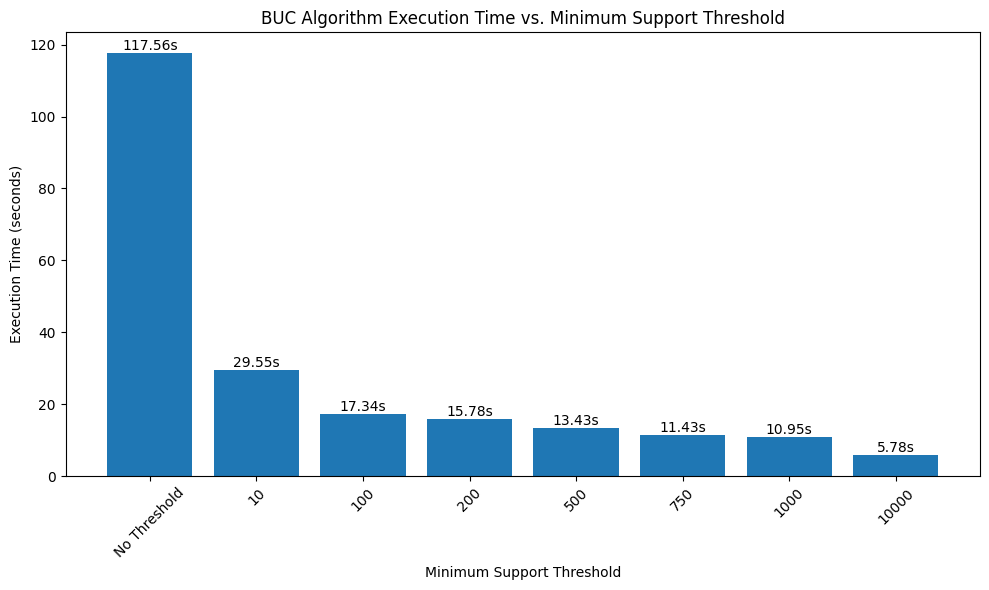

In [47]:
buc_in_memory = BUCInMemory(MAIN_DATA)

thresholds = [None, 10, 100, 200, 500, 750, 1000, 10000]
results_dict = buc_in_memory.run_with_varying_thresholds(thresholds)

buc_in_memory.plot_execution_times(results_dict)

# Additionally, to access the dataframe, use the below.
# result_df, time = results_dict[100]

* A plot of minsup vs. runtime, keeping allotted memory fixed.

Temporary files and output have been cleaned up.
Completed run with memory_limit=100000, min_support=100, runtime=122.18 seconds
Temporary files and output have been cleaned up.
Completed run with memory_limit=100000, min_support=200, runtime=100.80 seconds
Temporary files and output have been cleaned up.
Completed run with memory_limit=100000, min_support=500, runtime=84.25 seconds
Temporary files and output have been cleaned up.
Completed run with memory_limit=100000, min_support=750, runtime=80.27 seconds
Temporary files and output have been cleaned up.
Completed run with memory_limit=100000, min_support=1000, runtime=79.86 seconds
Temporary files and output have been cleaned up.
Completed run with memory_limit=100000, min_support=10000, runtime=72.30 seconds
Temporary files and output have been cleaned up.
Completed run with memory_limit=500000, min_support=100, runtime=133.75 seconds
Temporary files and output have been cleaned up.
Completed run with memory_limit=500000, min_suppo

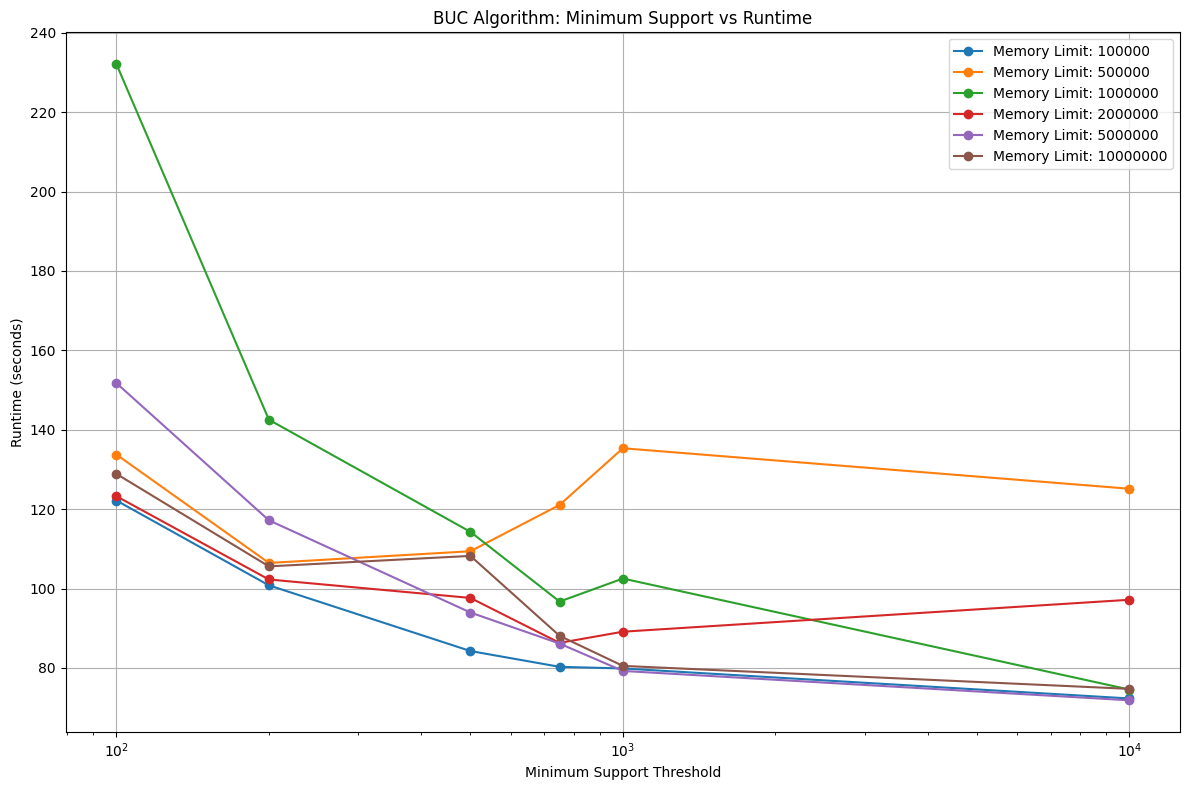

In [7]:
minimum_support_range = [100, 200, 500, 750, 1000, 10000]
memory_range = [100000, 500000, 1000000, 2000000, 5000000, 10000000]

# Plot memory limit vs. runtime (varying minimum supports)
plot_buc_runtime_multi(MAIN_DATA, fixed_param='memory_limit', vary_param='min_support', 
                       vary_ranges=minimum_support_range, fixed_values=memory_range)

* A plot of allotted memory vs. runtime, keeping minsup fixed.

Temporary files and output have been cleaned up.
Completed run with min_support=100, memory_limit=100000, runtime=129.22 seconds
Temporary files and output have been cleaned up.
Completed run with min_support=100, memory_limit=500000, runtime=130.04 seconds
Temporary files and output have been cleaned up.
Completed run with min_support=100, memory_limit=1000000, runtime=138.67 seconds
Temporary files and output have been cleaned up.
Completed run with min_support=100, memory_limit=2000000, runtime=147.74 seconds
Temporary files and output have been cleaned up.
Completed run with min_support=100, memory_limit=5000000, runtime=180.90 seconds
Temporary files and output have been cleaned up.
Completed run with min_support=100, memory_limit=10000000, runtime=189.61 seconds
Temporary files and output have been cleaned up.
Completed run with min_support=200, memory_limit=100000, runtime=147.30 seconds
Temporary files and output have been cleaned up.
Completed run with min_support=200, memory_

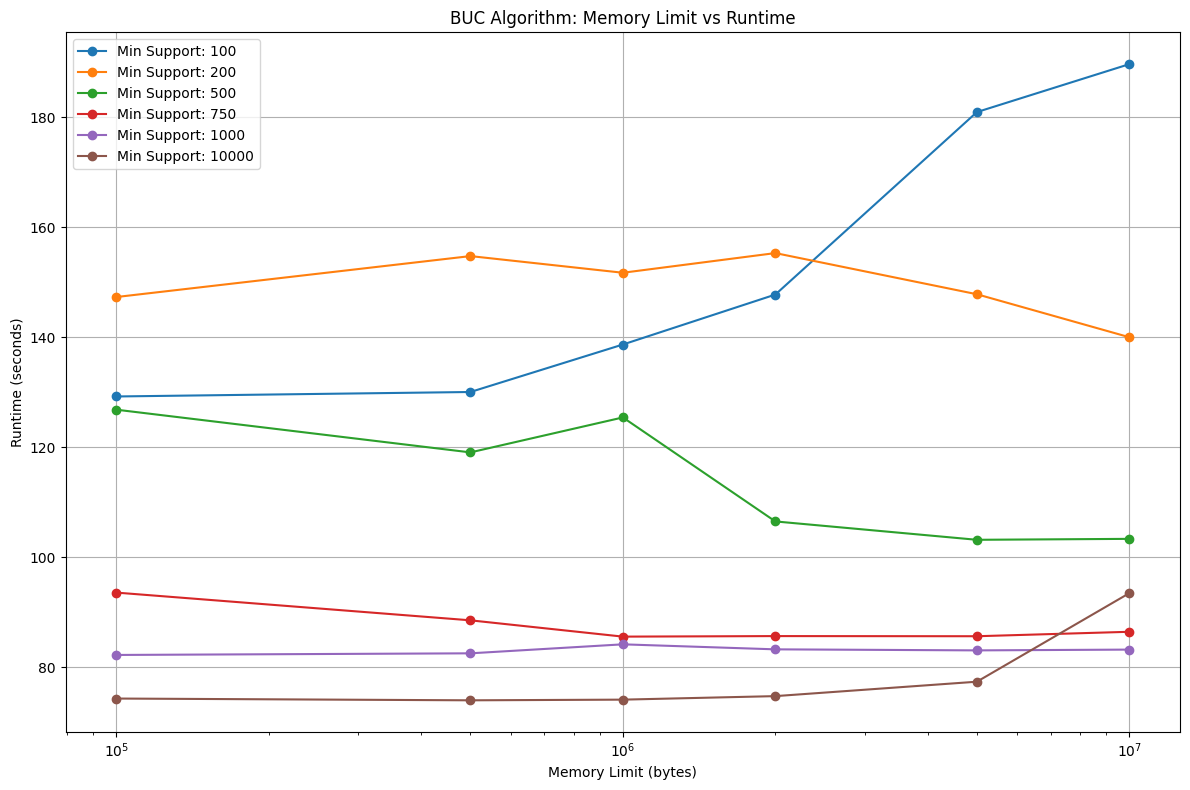

In [8]:
minimum_support_range = [100, 200, 500, 750, 1000, 10000]
memory_range = [100000, 500000, 1000000, 2000000, 5000000, 10000000]

# Plot minimum support vs. runtime (varying memory limits)
plot_buc_runtime_multi(MAIN_DATA, fixed_param='min_support', vary_param='memory_limit', 
                       vary_ranges=memory_range, fixed_values=minimum_support_range)

* From the above seen trends, we see that minimum support threshold at 100 shows us lots of variation compared to the rest, we suspect that the 1 MB might be causing more I/O operations than 2 MB, but not gaining the I/O reduction benefits of 500 KB. Another possible inference is that creating and deleting files for 1 MB partitions might interact poorly with the file system's block size or caching mechanisms.
* As expected, Runtime is expected to reduce with the increase in minsup. 
* A nice trend here with the fixed memory and variable minsup graph shows us that at higher minsup, the affect of memory is insignificant and can be noticed at >750 minsup. 
* Surprisingly, the first graph tells us that the algorithm ran best with the least memory usage for that run. 

## `AOI v/s BUC`

### -> Primary Purposes & Use cases

__BUC Algorithm__

> * Purpose: _BUC is primarily used for creating data cubes, which are multidimensional structures that allow for the aggregation and analysis of data across various dimensions._
>
> * Use Cases: _It's often employed in OLAP (Online Analytical Processing) environments to perform complex queries, enabling insights like sales trends over time, customer segmentation, and product performance analysis across regions._


__AOI Algorithm__

> * Purpose: _AOI is used for data generalization and knowledge discovery. It helps in simplifying data by abstracting or summarizing it to higher-level concepts._
>
> * Use Cases: _AOI is typically used in data mining to extract general patterns, trends, or rules from large datasets. It’s useful in scenarios like discovering demographic patterns, market basket analysis, and behavior analysis._


### -> Insights or Patterns Each Method is Best Suited to Discover

__BUC Algorithm__

> * Patterns: _BUC excels at discovering aggregated patterns across multiple dimensions, such as total sales by product category, region, and time. It’s useful for identifying trends and outliers in large, multidimensional datasets._
>
> * Example: _BUC could identify aggregated patterns such as the average `Base MSRP` of electric vehicles across different `Brand Regions` and `Model Years`. For example, it could reveal that electric vehicles in North America have a higher average `Base MSRP` in the `2022` model year compared to other regions._

__AOI Algorithm__

> * Patterns: _AOI is suited for discovering generalized patterns, such as customer buying behavior or general trends in demographic data. It focuses on summarizing data at higher abstraction levels, making it easier to interpret and extract meaningful insights._
>
> * Exmaple: _AOI could generalize data to identify broader trends, such as summarizing the `Electric Range` of vehicles into categories (e.g., "short," "medium," "long" range). This might reveal that "long-range" vehicles are more common in certain `Brand Countries` or that `CAFV Eligible` vehicles predominantly have "medium" to "long" ranges._


### -> Computational Efficiency and Scalability

__BUC Algorithm__

> * Efficiency: _BUC is relatively efficient when dealing with sparse data cubes because it only processes non-empty cells. However, as the number of dimensions increases, the computational cost can grow exponentially._
>
> * Scalability: _BUC scales well with sparse data but can struggle with dense, high-dimensional datasets due to the exponential growth of possible aggregations._
>
> * Example: _When analyzing vehicle data across multiple dimensions like `Brand`, `Model Year`, and `Location`, BUC can efficiently handle sparse data by focusing on non-empty combinations. However, if every `Brand` has vehicles in every `Location` across all `Model Years`, the algorithm may struggle with the sheer number of combinations. If you were to add more dimensions, such as `Electric Utility` or `Cardinal Direction`, BUC could face challenges as the data cube’s size increases exponentially. This might lead to slower query times and increased computational overhead._

__AOI Algorithm__

> * Efficiency: _AOI is generally efficient because it reduces the dataset by abstracting it to higher levels, which lowers the computational complexity._
>
> * Scalability: _AOI scales well with large datasets because it simplifies the data. However, it might lose some granularity, which could be important depending on the use case._
>
> * Example: _AOI could efficiently process this dataset by generalizing attributes, such as summarizing `Base MSRP` into price categories (e.g., "low," "medium," "high"). This reduces the dataset size and complexity, making it easier to analyze broader trends. Even with additional data like new vehicle features or more granular `Location` data, AOI can scale well because it abstracts detailed information into higher-level categories, minimizing the computational burden._


### -> Interpretability of the Results

__BUC Algorithm__

> * Interpretability: _The results of BUC, typically data cubes, are highly interpretable as they provide clear, structured views of aggregated data. Users can easily drill down or roll up through dimensions to explore different levels of detail._

__AOI Algorithm__

> * Interpretability: _AOI results are also interpretable but in a different way. The generalized rules or patterns it produces are easy to understand but might be less detailed, providing a more abstract view of the data._


### Scenarios Where One Might Be Preferable Over the Other

__BUC Algorithm__

> * Scenario: _If you need to analyze the impact of `Model Year` and `Brand Region` on `Base MSRP`, BUC would allow you to drill down and explore detailed multidimensional combinations. This would be crucial if you were trying to understand specific market segments, like high-end electric vehicles in Europe over the last five years._

> * Example: _Using BUC, you could find that the `Base MSRP` for `Electric Vehicle Type` "Sedan" in `Brand Region` "Asia" has consistently been lower compared to North America for the `Model Years` 2018-2022._

__AOI Algorithm__

> * Scenario: _AOI is ideal if you want to extract general patterns, such as understanding which `Brand Countries` are more likely to produce `CAFV Eligible` vehicles. This would be useful for generating high-level business strategies or market predictions._

> * Example: _With AOI, you might discover that "European brands are more likely to produce `CAFV Eligible` vehicles with a `Base MSRP` in the 'high' category," giving you a broad understanding of market positioning without delving into granular details._